In [43]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import neurodynex3.tools.input_factory as input_factory

In [44]:
def plot_data(state_monitor, title=None):
    """Plots the state_monitor variables ["vm", "I_e", "m", "n", "h"] vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    plt.subplot(311)
    plt.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2)

    plt.xlabel("t [ms]")
    plt.ylabel("v [mV]")
    plt.grid()

    plt.subplot(312)

    plt.plot(state_monitor.t / b2.ms, state_monitor.m[0] / b2.volt, "black", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.n[0] / b2.volt, "blue", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.h[0] / b2.volt, "red", lw=2)
    plt.xlabel("t (ms)")
    plt.ylabel("act./inact.")
    plt.legend(("m", "n", "h"))
    plt.ylim((0, 1))
    plt.grid()

    plt.subplot(313)
    plt.plot(state_monitor.t / b2.ms, state_monitor.I_e[0] / b2.uamp, lw=2)
    plt.axis((
        0,
        np.max(state_monitor.t / b2.ms),
        min(state_monitor.I_e[0] / b2.uamp) * 1.1,
        max(state_monitor.I_e[0] / b2.uamp) * 1.1
    ))

    plt.xlabel("t [ms]")
    plt.ylabel("I [micro A]")
    plt.grid()

    if title is not None:
        plt.suptitle(title)

    plt.show()

In [70]:
def regular_spiking(input_current, simulation_time):
    # neuron parameters
    gNa = 50 * b2.msiemens
    ENa = 50 * b2.mV
    gK  = 5 * b2.msiemens
    EK = -90 * b2.mV
    
    C = 1 * b2.ufarad

    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa * m**3 * h * (vm - ENa) : amp
    dm/dt = alpham*(1-m)-betam*m : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    alpham = (-1 * (0.32*(vm+47*mV)) / (exp(-0.25*((vm+47*mV)/mV))-1)  )/mV/ms : Hz
    betam = ((0.28 *(vm +20*mV)) / (exp(0.2 * ((vm +20*mV)/mV)) -1) )/mV/ms : Hz
    alphah = 0.128*exp(-1*((vm + 43*mV)/mV)/18) /ms    : Hz
    betah = 4./(exp(-0.2*((vm + 20*mV)/mV))+1) /ms : Hz
    
    I_K = gK * n**4 * (vm - EK) : amp
    dn/dt = alphan*(1-n)-betan*n : 1
    alphan = -1*(0.032*(vm+45*mV))/(exp(-0.2*((vm+45*mV)/mV))-1)  /mV/ms : Hz
    betan = (0.5 * exp(-1*(vm +50*mV)/mV/40)) / ms : Hz
    
    
    membrane_Im = I_e + I_Na + I_K : amp
    dvm/dt = membrane_Im/C : volt
    """
    
    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    neuron.vm = -385.410316948573 * b2.mV
    neuron.m = 1.9152321314413855e-37
    neuron.h = 1
    neuron.n = 1.345386283310858e-32

    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "I_Na", "I_K", "m", "n", "h"], record=True)

    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

In [95]:
def adaptive(input_current, simulation_time):
    # neuron parameters
    gNa = 50 * b2.msiemens
    ENa = 50 * b2.mV
    gK  = 5 * b2.msiemens
    EK  = -90 * b2.mV
    gM  = 0.07 * b2.msiemens
    
    C = 1 * b2.ufarad

    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa * m**3 * h * (vm - ENa) : amp
    dm/dt = alpham*(1-m)-betam*m : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    alpham = (-1 * (0.32*(vm+47*mV)) / (exp(-0.25*((vm+47*mV)/mV))-1)  )/mV/ms : Hz
    betam = ((0.28 *(vm +20*mV)) / (exp(0.2 * ((vm +20*mV)/mV)) -1) )/mV/ms : Hz
    alphah = 0.128*exp(-1*((vm + 43*mV)/mV)/18) /ms    : Hz
    betah = 4./(exp(-0.2*((vm + 20*mV)/mV))+1) /ms : Hz
    
    I_K = gK * n**4 * (vm - EK) : amp
    dn/dt = alphan*(1-n)-betan*n : 1
    alphan = -1*(0.032*(vm+45*mV))/(exp(-0.2*((vm+45*mV)/mV))-1)  /mV/ms : Hz
    betan = (0.5 * exp(-1*(vm +50*mV)/mV/40)) / ms : Hz
    
    I_M = gM * p * (vm - EK) : amp
    dp/dt = (p_inf - p) / tau_p : 1
    p_inf = 1/(exp(-0.1 * (vm+40*mV)/mV)+1) : 1
    tau_p = 2000 / (3.3 * exp((vm + 20*mV)/mV/20) + exp(-1*(vm + 20*mV)/mV/20)) * ms : second
    
    membrane_Im = I_e + I_Na + I_K + I_M : amp
    dvm/dt = membrane_Im/C : volt
    """
    
    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    neuron.vm = -385.410316948573 * b2.mV
    neuron.m = 1.9152321314413855e-37
    neuron.h = 1
    neuron.n = 1.345386283310858e-32
    neuron.p = 9.977472413315047e-16

    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "I_Na", "I_K", "I_M", "m", "n", "h", "p"], record=True)

    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

## Finding the initial parameters

WARNING    /tmp/ipykernel_7547/3785065202.py:29: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


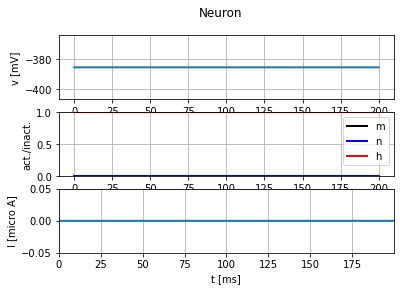

In [96]:
state_monitor = regular_spiking(input_factory.get_zero_current(), 200 * b2.ms)
plot_data(state_monitor, title="Neuron")

In [97]:
{
    'vm': state_monitor.vm[0].tolist()[-1],
    'h': state_monitor.h[0].tolist()[-1],
    'n': state_monitor.n[0].tolist()[-1],
    'm': state_monitor.m[0].tolist()[-1],
}

{'vm': -0.38541032 * volt,
 'h': 1.0,
 'n': 1.345386283310879e-32,
 'm': 1.9152321314414122e-37}

WARNING    /tmp/ipykernel_7547/3785065202.py:29: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


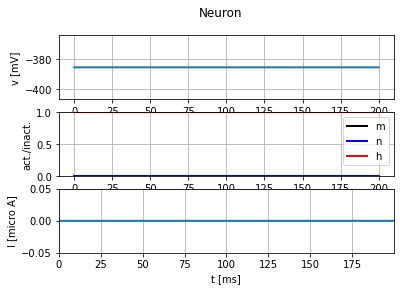

In [98]:
state_monitor = adaptive(input_factory.get_zero_current(), 200 * b2.ms)
plot_data(state_monitor, title="Neuron")

In [99]:
{
    'vm': state_monitor.vm[0].tolist()[-1],
    'h': state_monitor.h[0].tolist()[-1],
    'n': state_monitor.n[0].tolist()[-1],
    'm': state_monitor.m[0].tolist()[-1],
    'p': state_monitor.p[0].tolist()[-1],
}

{'vm': -0.38541032 * volt,
 'h': 1.0,
 'n': 1.345386283310879e-32,
 'm': 1.9152321314414122e-37,
 'p': 9.977472413315047e-16}